<a href="https://colab.research.google.com/github/G1useppe/ma5851_capstone_T0CE/blob/main/MACHINE_LEARNING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setup

In [125]:
from google.colab import drive #mounting google drive to access processing output

import pandas as pd #general
import numpy as np
from pprint import pprint

from sklearn.ensemble import RandomForestRegressor as rfR #machine learning
from sklearn.model_selection import train_test_split as tts 
from sklearn.model_selection import RandomizedSearchCV as rsCV
from sklearn import metrics

import matplotlib.pyplot as plt #visualization
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

from scipy import stats #wilcoxon test

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


To commence the third and final part of this workflow, we can bring in the data generated from our cleaning, wrangling and feature extraction.

In [ ]:
path = '/content/drive/MyDrive/feature_data.xlsx'
feature_data = pd.read_excel(path, na_values = 'NaN')
feature_data = feature_data.drop(["Unnamed: 0"], axis = 1)

# 4.1 Machine Learning Structure

## Train/Test Split

There was no need to deviate from conventional wisdom for the train/test split, and a 80/20 split was preferred.

In [ ]:
salary = feature_data[feature_data["Salary FTE"].notnull()]
no_salary = feature_data[feature_data["Salary FTE"].isnull()]

In [ ]:
y = list(salary["Salary FTE"])
X = salary.drop(["Salary FTE"], axis = 1) 

In [ ]:
X_train, X_test, y_train, y_test = tts(X, y, test_size = 0.2, random_state = 88)

## 4.1.1 Random Forest Selection Rationale and Structure

The random forest regressor was selected as the machine learning model due to the strong performance in the surveyed literature. In the work of Jackman & Reid (xxxx), it is the strongest performing model among the five regressors. In the work Martin et al. (xxxx), the random forest outpeforms all other models in a classification problem with the exception of voting classifiers, which are outside the scope of the course material. Additionally, Biau and Scornet (2015) praise the random forest algorithm for its 'ability to deal with small sample sizes and
high-dimensional feature spaces', which will be the case for the testing data set. 

To understand the structure of the random forest we first must understand the structure of a decision tree. In a machine learning capacity, decision trees are comprised of nodes that are trained to split observations in a manner such that the groups that it generates are as dissimilar to eachother as possible. The amount of nodes that makes up a tree, and the manner in which the nodes behave is constrained by user-specified parameters. A random forest is a collection of decision trees that operate as a community to make a decision. In the case of our regressor, each tree in the forest will make a prediction on the case which it is passed. Following this, the random forest will return the average prediction among the trees. The underlying concept behind the random forest is a simple one, strength in numbers. The essence that the decision trees all come from a seperate origin and are uncorellated is key to the process, where each tree can sample a fraction of the data, grow a tree, and contribute to the community aggregation.

The software to implement the machine learning will be RandomForestRegressor from scikit-learn. 

## 4.1.2 Hyperparameters

### Default Random Forest

To set a baseline for our machine learning investigation, and more importantly our hyperparameter optimization, a model was produced using default parameters from sklearn. The default parameters were returned and the model was subsequtly trained on the training set.

In [ ]:
default_rf = rfR(random_state = 90)
pprint(default_rf.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 90,
 'verbose': 0,
 'warm_start': False}


In [ ]:
default_rf.fit(X_train, y_train)

RandomForestRegressor(random_state=90)

The below helper function was written to save on doubling up, and generate some data to add to a data frame for the evluation.

In [112]:
def evaluator(model, X, y, verbose=True):
  predictions = model.predict(X) #predict the values
  errors = abs(predictions - y) #calculate the errors
  rmse = np.sqrt(((predictions - y) ** 2).mean())
  mae = np.mean(errors) #mean absolute error
  mape = 100 * np.mean(errors / y) #mean absolute percentage error
  accuracy = 100 - mape
  if verbose == True:
    print("Accuracy:                    " + str(round(accuracy, 2)) + "%")
    print("Mean Absolute Error:     AUD " + str(round(mae, 2)))
    print("Root Mean Squared Error: AUD " + str(round(rmse, 2)))
    print("These results have been saved in a list")
  return [accuracy, mae, rmse]

In [113]:
default_rf_metrics = evaluator(default_rf, X_train, y_train)

Accuracy:                    92.06%
Mean Absolute Error:     AUD 6997.69
Root Mean Squared Error: AUD 12908.28
These results have been saved in a list


The initial performance of the model is very strong, however it is caveated by potential overfitting. This can be attributed to the lack of cross-validation and the absence of constraint on the max_depth field.

In [ ]:
feature_importance = pd.Series(data = default_rf.feature_importances_, index = X_train.columns)
feature_importance.sort_values(ascending = False)[0:10]

desc_collaborate               0.148090
desc_scientific                0.085344
desc_leave                     0.065313
desc_torres strait islander    0.059231
company_health                 0.040645
desc_scientist                 0.039010
desc_strait islander           0.037315
desc_status                    0.031762
desc_test                      0.023296
desc_variety                   0.022073
dtype: float64

The variable importance for this model produced a surprising result, with the "collaborate" feature from the job description being twice as important as any other feature. One caveat with feature importance in a regressor is whether there is a 

### First Random Grid

The first step in improving our model is trying to tune the hyperparameters. The chosen tuning implementation was the Randmized Search Cross-Validation (rsCV) method from sci-kit learn, in which a random set from a parameter grid is iterated through with cross-validation. In our case, we propose a grid with 1,536 different parameter combinations. Given the provided constraints, rsCV will randomly choose 100 candidates and fit 8 folds on each. The advantage this model provides is the ability to narrow down a very wide hyperparameter search to provide a rough idea of where the best hyperparameters sit, without sacrificing the integrity of the fit. This method is designed to be an intermediate tune before a more focused tune down the line. 

In [ ]:
n_estimators = [100, 200, 400, 800]
max_features = ['sqrt', 'auto']
max_depth = [5, 10, 20, 40, 80, 160]
min_samples_leaf = [1, 2, 4, 8]
min_samples_split = [2, 4, 8, 16]
bootstrap = [False]

In [ ]:
params_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'bootstrap': bootstrap
}

In [ ]:
random_grid = rsCV(estimator = default_rf, param_distributions = params_grid, n_iter = 100, cv = 8, verbose = 2, n_jobs = -1, random_state = 90)

In [ ]:
random_grid.fit(X_train, y_train)
random_grid.best_params_

Fitting 8 folds for each of 100 candidates, totalling 800 fits


{'n_estimators': 400,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 40,
 'bootstrap': False}

In [ ]:
random_grid_metrics = evaluator(random_grid, X_train, y_train)

Accuracy:                    95.16%
Mean Absolute Error:     AUD 3552.21
Root Mean Squared Error: AUD 10711.53
These results have been saved in a list


This is admittedly a far better than expected result, yet amidst fears of overfitting, faith must be placed in the cross-validation. There is an increased sense of confidence that this is a robust model as the issues in the default model have been mitigated. Another positive result from this tune is that neither max_depth nor n_estimators took on the highest available value.

### Refined Random Grid

Using the best hyperparameters from the random grid to govern the selection, a new set of hyperparameters is proposed. rsCV is implemented to trial all 54 combinations, again across 8 folds.

In [ ]:
refined_grid = {
    'n_estimators': [300, 400, 600],
    'max_features': ['sqrt'],
    'max_depth': [30, 40, 60],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [3, 4, 5],
    'bootstrap': [False]
}

In [ ]:
refined_grid = rsCV(estimator = default_rf, param_distributions = refined_grid, cv = 8, n_iter=54, verbose = 2, n_jobs = -1, random_state = 90)

In [ ]:
refined_grid.fit(X_train, y_train)
refined_grid.best_params_

Fitting 8 folds for each of 54 candidates, totalling 432 fits


{'n_estimators': 400,
 'min_samples_split': 3,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': False}

In [ ]:
refined_grid_metrics =  evaluator(refined_grid, X_train, y_train)

Accuracy:                    95.78%
Mean Absolute Error:     AUD 3157.43
Root Mean Squared Error: AUD 10672.39
These results have been saved in a list


Again this is a staggering result given the refinement still offers a small improvement over the first tuning pass. Comparing the best parameters, two out of the four metrics that were provided scope to change did so. Given only a fraction of a percentage was gained in this tune, it is likely the law of diminshing returns would hamper any further tuning, so this model can be used for testing and cross-validation. It is unlikely that this sort of accuracy will be observed across the testing set, but due faith must be placed in the robust tunes that have been performed.

In [134]:
feature_importance = pd.Series(data = refined_grid.best_estimator_.feature_importances_, index = X_train.columns)
feature_importance.sort_values(ascending = False)

desc_collaborate      0.046057
desc_leave            0.033677
desc_scientific       0.031374
desc_scientist        0.027417
company_health        0.027272
                        ...   
title_research        0.000000
company_department    0.000000
title_ai              0.000000
company_science       0.000000
company_rmit          0.000000
Length: 308, dtype: float64

### Model Testing 

In [ ]:
test_metrics = evaluator(refined_grid, X_test, y_test)

Accuracy:                    97.96%
Mean Absolute Error:     AUD 1800.49
Root Mean Squared Error: AUD 5364.0
These results have been saved in a list


It isn't often that a test pass yields better results than the tuning phase, and there is certainly a requiem for cross-validation before passing definitive comments on model performance.

### Cross-validation

In [117]:
cv_data = []
for i in range(10):
  X_train_cv, X_test_cv, y_train_cv, y_test_cv = tts(X, y, test_size = 0.2)
  row = evaluator(refined_grid, X_test_cv, y_test_cv, verbose = False)
  cv_data.append(row)
cv_df = pd.DataFrame(cv_data, columns = ['Accuracy', 'MAE', 'RMSE'])
test_cv = [cv_df.Accuracy.mean(), cv_df.MAE.mean(), cv_df.RMSE.mean()]
cv_df

,Accuracy,MAE,RMSE
0,98.584400,1487.671922,4031.228423
1,95.706313,2854.023127,11472.985849
2,96.871606,2893.897266,9310.054280
3,98.838347,1212.164354,4239.974271
4,98.236494,1676.406170,6110.319377
5,98.688274,1127.464595,4794.994789
6,93.266655,5147.727735,14826.870464
7,96.740420,2462.447753,9135.005028
8,89.478794,7487.913990,17381.229349
9,95.529801,4000.711143,9015.005719


Now that the model has been cross-validated, model performance evaluation can begin.

## 4.1.3 A note on computation

During the proposal for this work, sources of GPU were discussed for the machine learning component. The decision to use a random forest regressor on sklearn eliminated the need for GPU computation, as it is programmed for CPU only.

# 4.2 Evaluation

## 4.2.1 Evaluation of performance

In [121]:
evaluation_data = [default_rf_metrics, random_grid_metrics, refined_grid_metrics, test_metrics, test_cv]
evaluation_df = pd.DataFrame(evaluation_data, columns = ['Accuracy', 'MAE', 'RMSE'])
evaluation_df.insert(0, "Model", 
                     ["default_rf", "random_grid", "refined_grid", "refined_grid", "refined_grid"])
evaluation_df.insert(1, "Features", 
                     ["X_train" , "X_train", "X_train", "X_test", "10-fold CV"])
evaluation_df

,Model,Features,Accuracy,MAE,RMSE
0,default_rf,X_train,92.055871,6997.691156,12908.280392
1,random_grid,X_train,95.160234,3552.211525,10711.530219
2,refined_grid,X_train,95.781688,3157.434777,10672.390238
3,refined_grid,X_test,97.960155,1800.491259,5364.002530
4,refined_grid,10-fold CV,96.194111,3035.042805,9031.766755


The above table shows the learning evaluation from each training fit, and the evaluation of the fit of the chosen model on the testing data. The cross-validated test performed with very similar accuracy to the refined grid model on the testing data. The overall conclusion is that the model is extremely effective at predicting salaries of data science job postings. This can be attributed to two key processes along the way.

1.   Considered and deliberate feature extraction. Although the feature extraction could be considered excessive due to the null importance of some features, a very high proportion of that signal in the data was captured.
2.   Sensible tuning. The two-phase tuning allowed the model to cover a lot of the parameter domain without an exhaustive computational cost, and then allowed it the capacity to subsequently fine tune. The ability to cross-validate the fits is also intepreted as an essential process to delivering a well-fitted model.



## 4.2.2 Visualization

In the plot below, the predicted salary values among the original testing data are plotted against the actual data to investigate any bias in the residuals. This plot reflects the strength of the model, as there is no visible pattern in the residuals. Furthermore, there are no causes for alarm or any glaring model deficiencies exhibitied.

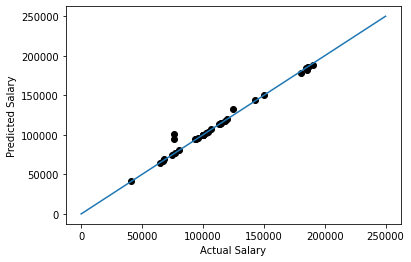

In [122]:
test_predictions = refined_grid.predict(X_test)
fig, ax = plt.subplots()
ax.scatter(x = y_test, y = test_predictions, c='black')
ax.plot([1, 200, 4000, 250000], [1, 200, 4000, 250000])
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.show()

## 4.2.3 Data limitations and sampling bias

As discussed in the proposal, the primary vector to investigate sampling bias is to run the predictor on the values that did not contain a salary. The intent is to randomly sample this set to match the size of the salaried data 10 times, and run a Wilcoxon Signed Rank Test to determine with statistical assertion whether or not there is a difference in the means. This evaluation is by no means intended to evaluate conclusive sampling bias, however it is intended to provide some perspective surrounding the school of thought that companies that do not advertise salary may choose to do so given their lacklustre offering capacity.

In [133]:
no_salary_X = no_salary.drop(["Salary FTE"], axis = 1) 
wilcoxon_data = []
for i in range(10):
  X_sample = no_salary_X.sample(n = len(y))
  predictions = refined_grid.predict(X_sample)
  res = stats.wilcoxon(y, predictions)
  if res.pvalue < 0.05:
    null_hyp = "Reject"
  else:
    null_hyp = "Uphold"
  row = [res.pvalue, null_hyp, round(sum(y)/len(y), 2), round(sum(predictions)/len(predictions),2)]
  wilcoxon_data.append(row)
wilcoxon_df = pd.DataFrame(wilcoxon_data, 
                           columns = ["P-value", "Null Hypothesis", 
                                      "Mean Salary (Known)", "Mean Salary (Predicted)"])
wilcoxon_df

,P-value,Null Hypothesis,Mean Salary (Known),Mean Salary (Predicted)
0,2.146014e-06,Reject,106469.23,118505.90
1,9.900820e-06,Reject,106469.23,117448.32
2,8.089791e-07,Reject,106469.23,119322.69
3,1.088860e-09,Reject,106469.23,122993.08
4,7.903581e-07,Reject,106469.23,119485.95
5,5.602793e-07,Reject,106469.23,119780.63
6,1.889171e-06,Reject,106469.23,119006.35
7,1.546316e-07,Reject,106469.23,120207.77
8,8.089908e-07,Reject,106469.23,120030.99
9,1.993233e-07,Reject,106469.23,120043.92


Whilst the null hypothesis was rejected on every occassion, indicating a statistically significant difference in means, the variation was in the opposite direction than what was predicted. From the results of this test, there are three interpretations.

1.   The likely presence of a form of sample bias and the elucidatation of limitations in the data. 
2.   The opening of converse line of thought, that perhaps the model serves not to predict a salary, rather to determine a salary for a job which is fair given the current market.
3.   Future work scopes to evaluate the above sentiments by using some more advanced webscraping techniques (discussed further in the next section).

## Future Considerations

*Webcrawler*: It is suspected that job listings that do not overtly express their salary are coerced to register a figure in the backend such that the jobs will not disappear when filtered by salary. A future project could incorporate an algorithm such as successive halving to try and estimate a job's salary.

*Processing*: Whilst the NLP used in this work was robust and effective, the field is evolving and advanced techniques could present another layer to the model. An interesting direction a future work could take is the incorporation of aspect-based granularity/sentiment analysis in a similar vein to the works of Pontiki et al. (2014) and Do et al. (2019)

*Machine Learning*: Moving towards a suite of tree based methods and/or a voting system would help protect the integrity of this work at a greater scale, especially on a dynamic time frame.

## References

Do HH, Prasad PWC, Maag A, Alsadoon A (2019). Deep learning for aspect-based sentiment analysis: acomparative review. Expert Syst Appl 118:272–299.

Pontiki M, Galanis D, Pavlopoulos J, Papageorgiou H,  Androutsopoulos I, Manandhar S (2014). Semeval-2014 task 4: Aspect based sentiment analysis. SemEval 2014:27-35.